In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/suitcaseluggage-dataset/annotation/annotation/Datacluster_Labs_Suitcase (67).xml
/kaggle/input/suitcaseluggage-dataset/annotation/annotation/Datacluster_Labs_Suitcase (17).xml
/kaggle/input/suitcaseluggage-dataset/annotation/annotation/Datacluster_Labs_Suitcase (64).xml
/kaggle/input/suitcaseluggage-dataset/annotation/annotation/Datacluster_Labs_Suitcase (5).xml
/kaggle/input/suitcaseluggage-dataset/annotation/annotation/Datacluster_Labs_Suitcase (135).xml
/kaggle/input/suitcaseluggage-dataset/annotation/annotation/Datacluster_Labs_Suitcase (20).xml
/kaggle/input/suitcaseluggage-dataset/annotation/annotation/Datacluster_Labs_Suitcase (15).xml
/kaggle/input/suitcaseluggage-dataset/annotation/annotation/Datacluster_Labs_Suitcase (6).xml
/kaggle/input/suitcaseluggage-dataset/annotation/annotation/Datacluster_Labs_Suitcase (14).xml
/kaggle/input/suitcaseluggage-dataset/annotation/annotation/Datacluster_Labs_Suitcase (137).xml
/kaggle/input/suitcaseluggage-dataset/annotation/a

In [2]:
!pip install supervision git+https://github.com/THU-MIG/yolov10.git

  Cloning https://github.com/THU-MIG/yolov10.git to /tmp/pip-req-build-35so8al5
  Running command git clone --filter=blob:none --quiet https://github.com/THU-MIG/yolov10.git /tmp/pip-req-build-35so8al5
  Resolved https://github.com/THU-MIG/yolov10.git to commit 36efe34fe1126a4ce639403f1ce16fa0edbc16fd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 3.1 MB/s eta 0:00:0000:01
  Created wheel for ultralytics: filename=ultralytics-8.1.34-py3-none-any.whl size=731248 sha256=00287ae7d00fc9f76b853d31c49b0592b6e6050a43e5d6c7b9e1a088db478097
  Stored in directory: /tmp/pip-ephem-wheel-cache-hf6tbqs1/wheels/43/69/ce/a29f8e396d41edc5db9476051cc64b70a69ade35dc81efbec9
Successfully built ultralytics


In [3]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 23 09:38 yolov10b.pt
-rw-r--r-- 1 root root 100M May 23 09:38 yolov10l.pt
-rw-r--r-- 1 root root  64M May 23 09:38 yolov10m.pt
-rw-r--r-- 1 root root  11M May 23 09:38 yolov10n.pt
-rw-r--r-- 1 root root  32M May 23 09:38 yolov10s.pt
-rw-r--r-- 1 root root 123M May 23 09:38 yolov10x.pt


In [4]:
!pip install xmltodict
import os
import glob
import xml.etree.ElementTree as ET
import torch
import torchvision
import cv2
from matplotlib import pyplot as plt
import numpy as np
import xmltodict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
def get_matching_files(image_folder, annotation_folder):
    image_files = sorted(glob.glob(os.path.join(image_folder, '*.jpg')))
    annotation_files = sorted(glob.glob(os.path.join(annotation_folder, '*.xml')))

    image_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in image_files}
    annotation_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in annotation_files}

    matching_files = []
    for image_name, image_path in image_dict.items():
        if image_name in annotation_dict:
            annotation_path = annotation_dict[image_name]
            matching_files.append((image_path, annotation_path))

    return matching_files

suitcases = "/kaggle/input/suitcaseluggage-dataset/suitcase/suitcase"
annotations = "/kaggle/input/suitcaseluggage-dataset/annotation/annotation"

files = get_matching_files(suitcases, annotations)

In [6]:
def extract_bounding_boxes_from_xml(xml_file):
    with open(xml_file) as f:
        data = xmltodict.parse(f.read())
    if 'object' not in data['annotation']:
        return []
    objects = data['annotation']['object']
    if isinstance(objects, dict):
        objects = [objects]
    bboxes = []
    for obj in objects:
        bbox = obj['bndbox']
        bboxes.append([
            int(float(bbox['xmin'])),
            int(float(bbox['ymin'])),
            int(float(bbox['xmax'])),
            int(float(bbox['ymax'])),
            obj['name']
        ])
    return bboxes

In [7]:
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = max(box1[0], box2[0]), max(box1[1], box2[1]), min(box1[2], box2[2]), min(box1[3], box2[3])
    inter_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

In [8]:
!yolo task=detect mode=predict conf=0.25 save=True model={HOME}/weights/yolov10n.pt

WARNING ⚠️ 'source' argument is missing. Using default 'source=/opt/conda/lib/python3.10/site-packages/ultralytics/assets'.
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (Intel Xeon 2.20GHz)
YOLOv10n summary (fused): 285 layers, 2762608 parameters, 63840 gradients, 8.6 GFLOPs

image 1/2 /opt/conda/lib/python3.10/site-packages/ultralytics/assets/bus.jpg: 640x480 4 0s, 1 5, 206.9ms
image 2/2 /opt/conda/lib/python3.10/site-packages/ultralytics/assets/zidane.jpg: 384x640 2 0s, 144.8ms
Speed: 8.4ms preprocess, 175.8ms inference, 17.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [9]:
from ultralytics import YOLOv10
model = YOLOv10("/kaggle/working/{HOME}/weights/yolov10n.pt")

In [10]:
true_labels = []
pred_labels = []

for image_path, annotation_path in files:
    img = cv2.imread(image_path)
    results = model(img)

    gt_boxes = extract_bounding_boxes_from_xml(annotation_path)

    if results[0].boxes is not None:
        pred_boxes = results[0].boxes.xyxy.cpu().numpy()
    else:
        pred_boxes = np.array([])
        
    count = 0

    for gt_box in gt_boxes:
        gt_bbox = gt_box[:4]
        gt_label = gt_box[4]
        
        for pred in pred_boxes:
            iou = calculate_iou(gt_bbox, pred[:4])
            if iou > 0.5: # Adjust as necessary for accuracy
                count += 1
                break
     
    print(f"PREDICTED: {count}, TRUE: {len(gt_boxes)}")
        
    pred_labels.append(count)
    true_labels.append(len(gt_boxes))


0: 640x480 (no detections), 191.9ms
Speed: 9.6ms preprocess, 191.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)
PREDICTED: 0, TRUE: 5

0: 640x480 1 0, 149.4ms
Speed: 4.7ms preprocess, 149.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
PREDICTED: 0, TRUE: 1

0: 640x480 1 0, 1 28, 184.5ms
Speed: 5.0ms preprocess, 184.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)
PREDICTED: 1, TRUE: 1

0: 640x480 3 28s, 195.9ms
Speed: 4.3ms preprocess, 195.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
PREDICTED: 1, TRUE: 1

0: 640x480 1 28, 213.4ms
Speed: 5.2ms preprocess, 213.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)
PREDICTED: 1, TRUE: 1

0: 640x480 1 28, 196.6ms
Speed: 4.4ms preprocess, 196.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
PREDICTED: 1, TRUE: 1

0: 640x480 1 0, 193.7ms
Speed: 5.8ms preprocess, 193.7ms inference, 2.1ms postprocess per image at shape (1

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


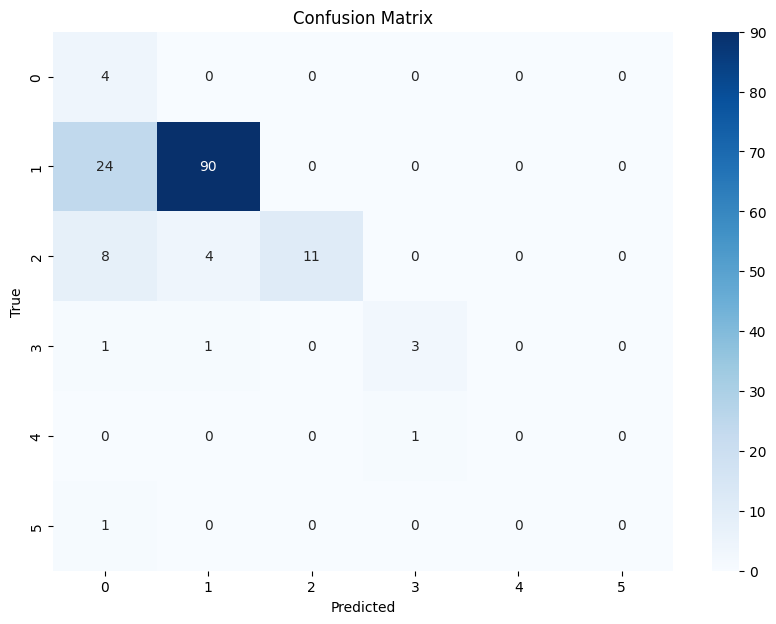

Classification Report
              precision    recall  f1-score   support

           0       0.11      1.00      0.19         4
           1       0.95      0.79      0.86       114
           2       1.00      0.48      0.65        23
           3       0.75      0.60      0.67         5
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.73       148
   macro avg       0.47      0.48      0.39       148
weighted avg       0.91      0.73      0.79       148



In [11]:
cm = confusion_matrix(true_labels, pred_labels)
report = classification_report(true_labels, pred_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report')
print(report)